In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import polars as pl
import tensorflow as tf
from ml_collections import ConfigDict
import temporal_fusion_transformer as tft
import jax
import jax.numpy as jnp
import numpy as np
from absl_extra import logging_utils, flax_utils
from tqdm.auto import tqdm
from keras.utils import FeatureSpace
import matplotlib
import matplotlib.pyplot as plt
import matplotx
import datetime
from datetime import datetime
import matplotlib.dates as mdates
from datetime import datetime


logging_utils.setup_logging(log_level="INFO")
matplotlib.style.use(matplotx.styles.dufte)


data_config = tft.experiments.get_config("electricity")
config = ConfigDict(
    {
        "prng_seed": 69,
        "model": {
            "num_attention_heads": 10,
            "num_decoder_blocks": 5,
            "latent_dim": 160,
            "dropout_rate": 0.1,
            "attention_dropout_rate": 0.1,
            "quantiles": [0.1, 0.5, 0.9],
        },
    }
)

ImportError: cannot import name 'ConfigDictProto' from 'temporal_fusion_transformer.src.config_dict' (/Users/artemsereda/Documents/IdeaProjects/temporal_fusion_transformer/temporal_fusion_transformer/src/config_dict.py)

Load model

In [3]:
model = tft.TemporalFusionTransformer.from_config_dict(config, data_config)

x_batch = jnp.ones([8, 8 * 24, 6])
rng_key = jax.random.PRNGKey(config.prng_seed)
params = model.init(rng_key, x_batch)["params"]
params = flax_utils.load_from_msgpack(params, "../model.msgpack")

2023-09-07 23:14:31,278:[xla_bridge.py:622->backends()]:INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-07 23:14:31,278:[xla_bridge.py:622->backends()]:INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-07 23:14:31,279:[xla_bridge.py:622->backends()]:INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


Load data & preprocessor

In [25]:
preprocessor: tft.experiments.electricity.PreprocessorDict = tft.experiments.deserialize_preprocessor(
    "../data/electricity"
)
dataset = tf.data.Dataset.load("../data/electricity/test/", compression="GZIP")

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17295488669516170944


Let's run inference for 1 entity only (MT_122)

In [51]:
preprocessor

{'categorical': {'day': LabelEncoder(),
  'day_of_week': LabelEncoder(),
  'hour': LabelEncoder(),
  'id': LabelEncoder(),
  'month': LabelEncoder()},
 'real': {'MT_001': StandardScaler(),
  'MT_002': StandardScaler(),
  'MT_003': StandardScaler(),
  'MT_004': StandardScaler(),
  'MT_005': StandardScaler(),
  'MT_006': StandardScaler(),
  'MT_007': StandardScaler(),
  'MT_008': StandardScaler(),
  'MT_009': StandardScaler(),
  'MT_010': StandardScaler(),
  'MT_011': StandardScaler(),
  'MT_012': StandardScaler(),
  'MT_013': StandardScaler(),
  'MT_014': StandardScaler(),
  'MT_015': StandardScaler(),
  'MT_016': StandardScaler(),
  'MT_017': StandardScaler(),
  'MT_018': StandardScaler(),
  'MT_019': StandardScaler(),
  'MT_020': StandardScaler(),
  'MT_021': StandardScaler(),
  'MT_022': StandardScaler(),
  'MT_023': StandardScaler(),
  'MT_024': StandardScaler(),
  'MT_025': StandardScaler(),
  'MT_026': StandardScaler(),
  'MT_027': StandardScaler(),
  'MT_028': StandardScaler(),
 

In [92]:
entity = "MT_370"
id_ = preprocessor["categorical"]["id"].transform([entity])[0]
id_

369

We know that our `id` input is on 5 position among features (see config). 
We also know, that every unbatched input i a self-contained time-series for 1 id.

In [94]:
mt_122_dataset = dataset.filter(lambda x, y: (x[..., 5] == id_)[0])
mt_122_dataset = list(mt_122_dataset.as_numpy_iterator())
len(mt_122_dataset)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17295488669516170944


337

In [95]:
x_batch = np.asarray([i[0] for i in mt_122_dataset])
y_batch = np.asarray([i[1] for i in mt_122_dataset])

In [96]:
y_batch

array([[[-0.16431321],
        [-0.16431321],
        [-0.16431321],
        ...,
        [-0.16431321],
        [-0.16431321],
        [-0.16431321]],

       [[-0.16431321],
        [-0.16431321],
        [-0.16431321],
        ...,
        [-0.16431321],
        [-0.16431321],
        [-0.16431321]],

       [[-0.16431321],
        [-0.16431321],
        [-0.16431321],
        ...,
        [-0.16431321],
        [-0.16431321],
        [-0.16431321]],

       ...,

       [[-0.16431321],
        [-0.16431321],
        [-0.16431321],
        ...,
        [-0.16431321],
        [-0.16431321],
        [-0.16431321]],

       [[-0.16431321],
        [-0.16431321],
        [-0.16431321],
        ...,
        [-0.16431321],
        [-0.16431321],
        [-0.16431321]],

       [[-0.16431321],
        [-0.16431321],
        [-0.16431321],
        ...,
        [-0.16431321],
        [-0.16431321],
        [-0.16431321]]], dtype=float32)

In [97]:
y_predicted = model.apply({"params": params}, x_batch)

y_batch.shape, y_predicted.shape

((337, 192, 1), (337, 24, 1, 3))

In [98]:
y_predicted

Array([[[[-0.17019959, -0.1685508 , -0.16083948]],

        [[-0.1689118 , -0.16863371, -0.15950868]],

        [[-0.16967326, -0.16836171, -0.16010945]],

        ...,

        [[-0.1690394 , -0.16853623, -0.15945195]],

        [[-0.16902867, -0.16864154, -0.15935074]],

        [[-0.16963875, -0.16877538, -0.16019094]]],


       [[[-0.16918434, -0.16880885, -0.15969636]],

        [[-0.169702  , -0.16835721, -0.16016367]],

        [[-0.16955888, -0.16860262, -0.15991735]],

        ...,

        [[-0.16902846, -0.16864148, -0.15935065]],

        [[-0.16963859, -0.16877536, -0.1601908 ]],

        [[-0.16965733, -0.16845615, -0.16020599]]],


       [[[-0.16984063, -0.16837604, -0.16028327]],

        [[-0.16956773, -0.1686201 , -0.15993008]],

        [[-0.16917744, -0.16855085, -0.1594212 ]],

        ...,

        [[-0.16963826, -0.16877529, -0.16019061]],

        [[-0.16965711, -0.16845612, -0.16020584]],

        [[-0.16888893, -0.16866857, -0.15946765]]],


       ...,


  

In [99]:
y_past = y_batch[:, :168]

y_past = preprocessor["target"][entity].inverse_transform(y_past.reshape(-1, 1))[..., 0]

y_future = y_batch[:, 168:]

x_past = x_batch[:, :168]

x_past.shape, y_past.shape

((337, 168, 6), (56616,))

In [102]:
y_past

array([16.814713, 16.814713, 16.814713, ..., 16.814713, 16.814713,
       16.814713], dtype=float32)

In [100]:
month = x_past[..., 1].reshape(-1).astype(np.int32)
month = preprocessor["categorical"]["month"].inverse_transform(month)
day = x_past[..., 2].reshape(-1).astype(np.int32)
day = preprocessor["categorical"]["day"].inverse_transform(day)
hour = x_past[..., 3].reshape(-1).astype(np.int32)
hour = preprocessor["categorical"]["hour"].inverse_transform(hour)

In [101]:
year = x_past[..., 0].reshape(-1, 1)
year = preprocessor["real"][entity].inverse_transform(year)
year

array([[2014.],
       [2014.],
       [2014.],
       ...,
       [2014.],
       [2014.],
       [2014.]], dtype=float32)

In [77]:
timestamps = [
    datetime(year=int(y), month=int(m), day=int(d), hour=int(h))
    for y, m, d, h in zip(year.reshape(-1), month, day, hour)
]
timestamps[1]

datetime.datetime(2014, 8, 25, 1, 0)

In [80]:
max(timestamps)

datetime.datetime(2014, 9, 8, 0, 0)

In [81]:
min(timestamps)

datetime.datetime(2014, 8, 25, 0, 0)

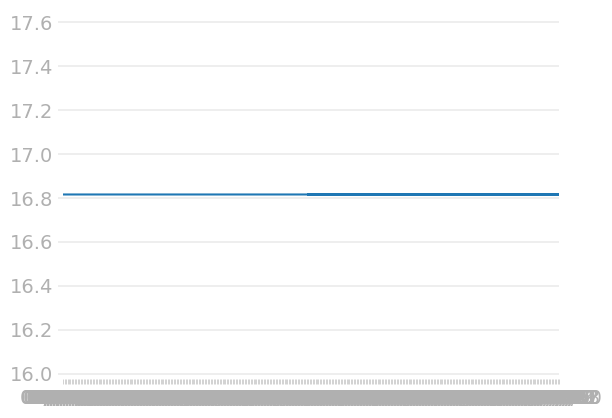

In [83]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%M/%d/%H"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
# TODO: how tf can we reconstruct the timestamp?

plt.plot(timestamps, y_past)
# plt.plot(range(168, 192), y_future[0])
# plt.plot(range(168, 192), y_predicted[0,:,0])
# plt.plot(range(168, 192), y_predicted[0,:,1])
# plt.plot(range(168, 192), y_predicted[0,:,2])
# plt.gcf().autofmt_xdate()

# plt.legend(["past", "future", "q=0.1", "q=0.5", "q=0.9"])

In [68]:
y_past

array([16.814713, 16.814713, 16.814713, ..., 16.814713, 16.814713,
       16.814713], dtype=float32)

In [14]:
x_past[..., 2].mean()

1.0

In [16]:
x_past[0].mean(axis=0)

array([350.      ,   1.      ,   1.      ,  17.857143,  11.5     ,
         3.      ,   0.      ], dtype=float32)